In [2]:
from src.models.CORAL_BART.dataset import KaggleDiffsReader, KaggleDiffsDataset
from src.models.CORAL_BART.utils import block_shuffle
from src.models.CORAL_BART.metrics import find_all_between_tags, calc_rouge_from_tokens,calc_span_aware_rouge, remove_ids

from transformers import BartTokenizerFast
from collections import Counter
import os
import json

from rouge import Rouge

import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, precision_score, accuracy_score, recall_score
from scipy.special import softmax

from tqdm.auto import tqdm

In [3]:
def load_jsonl(path):
    data = []
    with open(path) as f:
        for line in f:
            data.append(json.loads(line))
    return data

## Loading data as we do in the model:

In [4]:
path_to_tokenizer = "../../tokenizer"
vocab_path = os.path.join(path_to_tokenizer, "vocab.json")
merges_path = os.path.join(path_to_tokenizer, "merges.txt")
tokenizer = BartTokenizerFast(vocab_path, merges_path)

In [5]:
data_reader = KaggleDiffsReader("/homes/gws/mikeam/RobustDataScience/data/processed/filtered_less_than_5_lines.jsonl")

Loading Diffs: 69898it [00:03, 22364.44it/s]


In [6]:
#Using the same seed as the model:
data_reader.diffs = block_shuffle(
            data_reader.diffs, key_fn=lambda x: x["metadata"]["comp_name"],
            seed=421994)

In [7]:
eval_fraction = 0.05
base_dataset = KaggleDiffsDataset
max_length= 128
dataset_args = {"predict_spans": True,
                "p_mask_unchanged": 0,
                "replace_inserted_tokens_in_output": False}

n_examples = len(data_reader)
split_point = int(n_examples * (1 - eval_fraction))
train_dataset = base_dataset(
            data_reader.diffs[:split_point], tokenizer, max_length=max_length, **dataset_args)
eval_set = base_dataset(
            data_reader.diffs[split_point:], tokenizer, max_length=max_length, **dataset_args)

## Get token counts in train dataset

In [8]:
train_token_counts = Counter()
for d in train_dataset:
    train_token_counts.update(d["input_ids"])
    train_token_counts.update(d['decoder_input_ids'])

In [9]:
inverse_token_rank = {k:i for i, (k,v) in enumerate(train_token_counts.most_common(len(train_token_counts))[::-1])}

/homes/gws/mikeam/anaconda3/envs/RobustDataScience/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

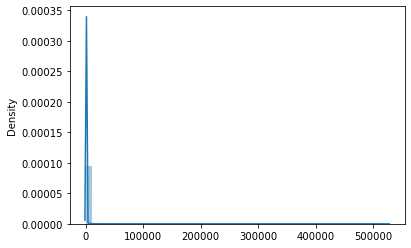

In [10]:
sns.distplot(list(train_token_counts.values()))

## Load model results:

In [11]:
FINAL_RESULTS_PATH = "../../results/final/"
final_results = {
    "Graph Loss":{"file":"deluxe.jsonl"},
    "No Graph Loss":{"file":"deluxe_no_graph.jsonl"},
    "Seq2Seq Loss Only":{"file":"seq2seq.jsonl"},
    "Oracle" : {"file":"deluxe_oracle.jsonl"},
    "Span Loss Only" : {"file":"deluxe_span_loss_only.jsonl"},
    "No SAD" : {"file" : "no_sad.jsonl"},
    "Half Span Loss": {"file":"0.5_unchanged.jsonl"}
}

In [14]:
for name, result in tqdm(final_results.items()):
    eval_output = load_jsonl(os.path.join(FINAL_RESULTS_PATH,result["file"]))
    pred_ids = [x["pred"] for x in eval_output]
    label_ids = [x["label_ids"] for x in eval_output]
    
    scores = {}
    rouge_score = calc_rouge_from_tokens(pred_ids, label_ids, tokenizer)
    final_results[name]["rouge-l-p"] = rouge_score["rouge-l"]["p"]
    final_results[name]["rouge-l-f"] = rouge_score["rouge-l"]["f"]
    final_results[name]["rouge-l-r"] = rouge_score["rouge-l"]["r"]
    
    span_aware_rouge = calc_span_aware_rouge(pred_ids, label_ids, tokenizer)
    final_results[name]["span-rouge-l-p"] = span_aware_rouge["rouge-l"]["p"]
    final_results[name]["span-rouge-l-f"] = span_aware_rouge["rouge-l"]["f"]
    final_results[name]["span-rouge-l-r"] = span_aware_rouge["rouge-l"]["r"]
    

In [18]:
# RESULTS_PATH = "../../results/mox-hyak/"
# results = {
#     "Graph Loss":{"file":"graph_loss_preds.jsonl"},
#     "No Graph Loss":{"file":"no_graph_loss_preds.jsonl"}
# }

start_token = 52000
end_token = 52001

#Load Data
for name, result in tqdm(final_results.items()):
    eval_output = load_jsonl(os.path.join(FINAL_RESULTS_PATH,result["file"]))
    
    if name not in ["Seq2Seq Loss Only", "Oracle"]:
        y_true = np.concatenate([x['classification_labels'] for x in eval_output])
        mask = y_true!= -100
        
        y_true = y_true[mask]
        y_prob = softmax(np.concatenate([x["classification_logits"] for x in eval_output])[:,-1])[mask]
        
        y_pred = (y_prob > 0.15).astype(int)
        
        final_results[name]["f1_score"] = f1_score(y_true,y_pred)
        final_results[name]["precision"] = precision_score(y_true,y_pred)
        final_results[name]["accuracy"] = accuracy_score(y_true,y_pred)
        final_results[name]["recall"] = recall_score(y_true,y_pred)
        final_results[name]["roc_auc"]= roc_auc_score(y_true,y_prob)
        
    for data in eval_output:
        pred = data["pred"]
        label = data["label_ids"]
        span_aware_rouge = calc_span_aware_rouge([pred], [label], tokenizer)
        
        data["pred_span"] = list(find_all_between_tags(pred,start_token,end_token))
        data["label_span"] = list(find_all_between_tags(label,start_token,end_token))
        
        data["pred_span"] = [item for sublist in data["pred_span"] for item in sublist]
        data["label_span"] = [item for sublist in data["label_span"] for item in sublist]
        
        data["span_rouge_l_f"] = span_aware_rouge["rouge-l"]["f"]
        data["span_rouge_l_p"] = span_aware_rouge["rouge-l"]["p"]
        data["span_rouge_l_r"] = span_aware_rouge["rouge-l"]["r"]
        
        
        rouge_score = calc_rouge_from_tokens([pred],[label],tokenizer)
        data["rouge-l-p"] = rouge_score["rouge-l"]["p"]
        data["rouge-l-f"] = rouge_score["rouge-l"]["f"]
        data["rouge-l-r"] = rouge_score["rouge-l"]["r"]
        
        data["avg_inverse_label_token_rank"] = np.mean([inverse_token_rank.get(x,0) for x in data["label_span"]])
        data["avg_label_token_count"] = np.mean([train_token_counts.get(x,0) for x in data["label_span"]])
        
        data["label_unseen_tokens"] = [x for x in data["label_span"] if train_token_counts.get(x,0) == 0]
        data["pred_unseen_tokens"] = [x  for x in data["pred_span"] if train_token_counts.get(x,0) == 0]
        data["label_contains_unseen"] = len(data["label_unseen_tokens"]) > 0 
        data["pred_contains_unseen"] = len(data["pred_unseen_tokens"]) > 0 
        
        data["unseen_in_both"] = set(data["label_unseen_tokens"]).intersection(set(data["pred_unseen_tokens"]))
        data["unseen_in_label_and_pred"] = len(data["unseen_in_both"]) > 0
    
    final_results[name]["eval_output"] = eval_output

/homes/gws/mikeam/anaconda3/envs/RobustDataScience/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/gws/mikeam/anaconda3/envs/RobustDataScience/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/homes/gws/mikeam/anaconda3/envs/RobustDataScience/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gws/mikeam/anaconda3/envs/RobustDataScience/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

In [ ]:
print(final_results["Graph Loss"]["eval_output"][0])

## Put all results in one DataFrame for plotting

In [ ]:
all_results = []
for name, result in final_results.items():
    print(name)
    eval_output = final_results[name]["eval_output"]
    all_results.extend([{**{"Model Name":name}, **x} for x in eval_output])
all_results = pd.DataFrame(all_results)

In [ ]:
all_results["Model Name"].value_counts()

In [ ]:
sns.kdeplot(x="avg_inverse_label_token_rank", y="span_rouge_l_f",
            data = all_results.dropna(), hue="Model Name")

In [ ]:
sns.kdeplot(x="avg_label_token_count", y="span_rouge_l_f",
            data = all_results.dropna(), hue="Model Name")

In [ ]:
all_results.groupby(["Model Name","label_contains_unseen"])[["rouge-l-f","rouge-l-p","rouge-l-r","span_rouge_l_p","span_rouge_l_r","span_rouge_l_f"]].mean()

In [ ]:
for name, result in tqdm(final_results.items()):
    eval_output = load_jsonl(os.path.join(FINAL_RESULTS_PATH,result["file"]))
    
    if name not in ["Seq2Seq Loss Only", "Oracle"]:
        y_true = np.concatenate([x['classification_labels'] for x in eval_output])
        mask = y_true!= -100
        
        y_true = y_true[mask]
        y_prob = softmax(np.concatenate([x["classification_logits"] for x in eval_output]),axis=1)[:,-1][mask]
        
        y_pred = (y_prob > 0.15).astype(int)
#         print(y_pred)
#         import ipdb; ipdb.set_trace()
        final_results[name]["f1_score"] = f1_score(y_true,y_pred)
        final_results[name]["precision"] = precision_score(y_true,y_pred)
        final_results[name]["accuracy"] = accuracy_score(y_true,y_pred)
        final_results[name]["recall"] = recall_score(y_true,y_pred)
        final_results[name]["roc_auc"]= roc_auc_score(y_true,y_prob)

all_results.groupby(["Model Name"])[["rouge-l-p","rouge-l-r","rouge-l-f","span_rouge_l_p","span_rouge_l_r","span_rouge_l_f"]].mean()

## Classification 

In [ ]:
class_results = []
for name in final_results.keys():
    model_class_results = {}
    model_class_results["Model Name"] = name
    model_class_results["f1_score"]  = final_results[name].get("f1_score" )
    model_class_results["precision"] = final_results[name].get("precision")
    model_class_results["accuracy"]  = final_results[name].get("accuracy")
    model_class_results["recall"]  = final_results[name].get("recall")
    model_class_results["roc_auc"] = final_results[name].get("roc_auc")
    class_results.append(model_class_results)
class_results = pd.DataFrame(class_results)

In [ ]:
class_results

## Examples
Pull out some examples to use for our random evaluation

In [2]:
results_our_model = all_results[all_results["Model Name"] == "Graph Loss"]

NameError: name 'all_results' is not defined

In [ ]:
def display_sample(df):
    for index, row in df.iterrows():
        print("-"*20 + "Input" +"-"*20 )
        print(row["input"])
        print("-"*20 + "Label" +"-"*20 )
        print(row["label"])
        print("-"*20 + "Pred" +"-"*20 )
        print(row["prediction"])

In [ ]:
disply_sample(results_our_model.sample())

In [ ]:

disply_sample(results_our_model.sample())

In [ ]:
disply_sample(results_our_model[results_our_model["prediction"].str.contains("entropy")].sample())

In [1]:
print(results_our_model.iloc[47]["label"])

NameError: name 'results_our_model' is not defined

In [ ]:
print(results_our_model.iloc[47]["prediction"])

In [ ]:
print(results_our_model.iloc[47]["input"])

In [ ]:
print(results_our_model.iloc[956]["label"])

In [ ]:
print(results_our_model.iloc[956]["prediction"])

In [ ]:
results_our_model[results_our_model["prediction"].str.contains(">")].sample(10)

In [ ]:
print(results_our_model.iloc[1780]["input"])

In [ ]:
print(results_our_model.iloc[1780]["label"])

In [ ]:
print(results_our_model.iloc[1780]["prediction"])